In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

__1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.__

In [2]:
path_energy = '../data/my_PJME_MW.csv'
df_energy = pd.read_csv(path_energy, index_col=[0], parse_dates=[0])

In [3]:
energy_w = df_energy.copy().resample('W').mean()
energy_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


После ресемплинга большая часть параметров, связанная с датой стала неактуальной. Некоторые параметры стали ошибочными только в некоторых наблюдения (month = 1.42, к примеру, из-за усреднения), а некоторые стали полностью неверными (dayofweek). Поэтому необходимо полностью пересобрать недельную базу потребления энергии.

In [4]:
# удалим больше неактуальные колонки из-за ресемплинга
energy_w.drop(columns=['year', 
                       'month', 
                       'dayofmonth', 
                       'quarter', 
                       'dayofyear', 
                       'weekofyear', 
                       'dayofweek', 
                       'hour', 
                       'is_holiday', 
                       'is_prev_holiday', 
                       'is_next_holiday'], inplace=True)

In [5]:
energy_w['year'] = energy_w.index.year
energy_w['month'] = energy_w.index.month
energy_w['quarter'] = energy_w.index.quarter
energy_w['weekofyear'] = energy_w.index.weekofyear
energy_w['n_holidays'] = np.round(df_energy['is_holiday'].copy().resample('W').sum()/24).values.astype('int16')
energy_w.head()

,PJME_MW,year,month,quarter,weekofyear,n_holidays
Date,,,,,,
2002-01-06,32392.160839,2002,1,1,1,1
2002-01-13,31487.386905,2002,1,1,2,0
2002-01-20,31452.880952,2002,1,1,3,0
2002-01-27,30141.529762,2002,1,1,4,1
2002-02-03,29196.488095,2002,2,1,5,0


__2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.__

Сгенерируем новые параметры.

In [6]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = energy_w.drop(columns='n_holidays').values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

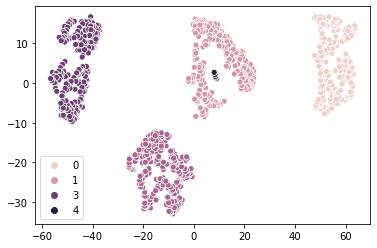

In [7]:
clast_0 = DBSCAN(eps=3, leaf_size=15)
clast_1 = DBSCAN(eps=3, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

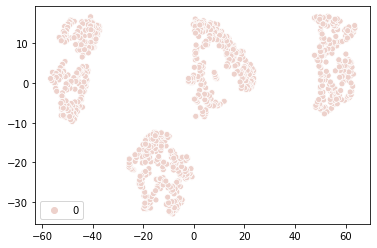

In [8]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast)
plt.show()

In [9]:
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров: ',len(np.unique(X_clast)))

Число кластеров с масштабированием:  1
Число кластеров:  5


При данном ресемплинге нельзя однозначно выполнить кластеризацию для небольшого количества классов, т.к. у нас нет категориальных переменных, количество классов ни к чему не привязано, поэтому не будем использовать кластеризацию.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full').fit(Xscale[:,1:])

print(f"Потеря объяснения дисперсии за счет применения PCA: {1 - sum(pca.explained_variance_ratio_):%}")

Потеря объяснения дисперсии за счет применения PCA: 2.461281%


Потери при использовании PCA небольшие, так что можем применить данный метод на данных.

In [11]:
Xpca=pca.transform(Xscale[:,1:])

energy_w['pca_1']=Xpca[:,0]
energy_w['pca_2']=Xpca[:,1]

Добавим логарифм от 'PJME_MW'.

In [12]:
energy_w['log_mw'] = np.log(energy_w['PJME_MW'])

Добавим скользящие средние с глубиной 4 и 5 недели (примерно месяц).

In [13]:
energy_w['roll_4'] = energy_w['PJME_MW'].rolling(window=4).mean()
energy_w['roll_5'] = energy_w['PJME_MW'].rolling(window=5).mean()

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

for a in range(1, 9):
    energy_w[f'exp_0_0{a}'] = exponential_smoothing(energy_w['PJME_MW'], a*0.01)

Автокорреляционный анализ.

In [15]:
from  statsmodels.graphics.tsaplots import plot_pacf, plot_acf

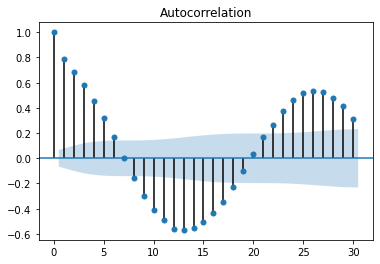

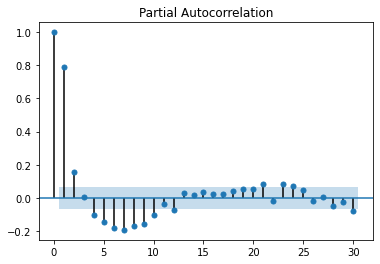

In [16]:
weeks = 30

plot_acf(energy_w['PJME_MW'].values, lags=weeks)
plot_pacf(energy_w['PJME_MW'].values, lags=weeks)
plt.show()

Добавим историю на глубину 14 и разности порядка от 1 до 7 на основании графиков ACF и PACF.

In [17]:
q = 14
for i in range(q):
    energy_w['q_'+str(i+1)] = 0.
    energy_w['q_'+str(i+1)].values[i+1:] = energy_w['PJME_MW'].values[:-(i+1)]

In [18]:
energy_w[[f'q_{i}' for i in range(1, q+1)]][:q+1]

,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,q_10,q_11,q_12,q_13,q_14
Date,,,,,,,,,,,,,,
2002-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-13,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-20,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-27,31452.880952,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-03,30141.529762,31452.880952,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-10,29196.488095,30141.529762,31452.880952,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-17,31150.517857,29196.488095,30141.529762,31452.880952,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-24,30616.565476,31150.517857,29196.488095,30141.529762,31452.880952,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-03-03,29144.130952,30616.565476,31150.517857,29196.488095,30141.529762,31452.880952,31487.386905,32392.160839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
p = 7
for i in range(1, p+1):
    energy_w['p_'+str(i)] = energy_w['PJME_MW'].diff(i).fillna(0)

In [20]:
energy_w[[f'p_{i}' for i in range(1, p+1)]][:p+1]

,p_1,p_2,p_3,p_4,p_5,p_6,p_7
Date,,,,,,,
2002-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-13,-904.773934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-20,-34.505952,-939.279887,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-27,-1311.351190,-1345.857143,-2250.631077,0.000000,0.000000,0.000000,0.000000
2002-02-03,-945.041667,-2256.392857,-2290.898810,-3195.672744,0.000000,0.000000,0.000000
2002-02-10,1954.029762,1008.988095,-302.363095,-336.869048,-1241.642982,0.000000,0.000000
2002-02-17,-533.952381,1420.077381,475.035714,-836.315476,-870.821429,-1775.595363,0.000000
2002-02-24,-1472.434524,-2006.386905,-52.357143,-997.398810,-2308.750000,-2343.255952,-3248.029887


In [21]:
print(f"Все наши признаки:\n {energy_w.columns}")

Все наши признаки:
 Index(['PJME_MW', 'year', 'month', 'quarter', 'weekofyear', 'n_holidays',
       'pca_1', 'pca_2', 'log_mw', 'roll_4', 'roll_5', 'exp_0_01', 'exp_0_02',
       'exp_0_03', 'exp_0_04', 'exp_0_05', 'exp_0_06', 'exp_0_07', 'exp_0_08',
       'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10',
       'q_11', 'q_12', 'q_13', 'q_14', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5',
       'p_6', 'p_7'],
      dtype='object')


Проведем анализ признаков, добавим в общий анализ интегральные признаки (календарь), для упрощения процесса анализа.

Применим F-test, SelectKBest и SelectPercentile.

In [22]:
scl_target=StandardScaler()

g = max(p, q) # максимальная глубина с нулевыми значениями
h = 4

target = energy_w['PJME_MW'].values[h+g:].reshape((energy_w.shape[0]-h-g, 1))
y = scl_target.fit_transform(target)

In [23]:
scl_x=StandardScaler() 

X = energy_w.iloc[g:-h, :].values
X = scl_x.fit_transform(X.astype('float64'))

In [24]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

best_f_score_colmns = []
threshold_f = 0.5 # порог важности признака

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
#     print("F-test={:.2f},  I={}".format(f_test[i],i))
    if f_test[i] > threshold_f:
        best_f_score_colmns.append(i)

In [25]:
column_names_f = energy_w.iloc[g:-h,:].columns[best_f_score_colmns]
print(column_names_f)

Index(['q_8', 'q_9', 'q_10', 'p_4', 'p_5', 'p_6', 'p_7'], dtype='object')


In [26]:
sfk = SelectKBest(f_regression, k=7)
X_new1 = sfk.fit_transform(X, y.ravel())
column_names_k = energy_w.columns[sfk.get_support()]
column_names_k

Index(['q_8', 'q_9', 'q_10', 'p_4', 'p_5', 'p_6', 'p_7'], dtype='object')

In [27]:
sfp = SelectPercentile(f_regression, percentile=15)
X_new2 = sfp.fit_transform(X, y.ravel())
column_names_p = energy_w.columns[sfp.get_support()]
column_names_p

Index(['q_8', 'q_9', 'p_4', 'p_5', 'p_6', 'p_7'], dtype='object')

In [28]:
list_param = list(set(column_names_f.append(column_names_k).append(column_names_p)))
print(list_param)

['p_7', 'q_8', 'p_4', 'q_10', 'p_6', 'q_9', 'p_5']


Данные методы дали очень хорошее объединение признаков.

In [29]:
numb_columns = [energy_w.columns.get_loc(param) for param in list_param]
X_new = X[:, numb_columns]

Разделим данные на train и test.

In [30]:
def split_data_proportion(data, part=1, need_split_date=False):
    split_date = data.index[round(data.shape[0] * part)]
    train = data.loc[data.index <= split_date].copy()
    test = data.loc[data.index >  split_date].copy()
    
    if need_split_date: 
        return train, test, str(split_date)
    else:
        return train, test

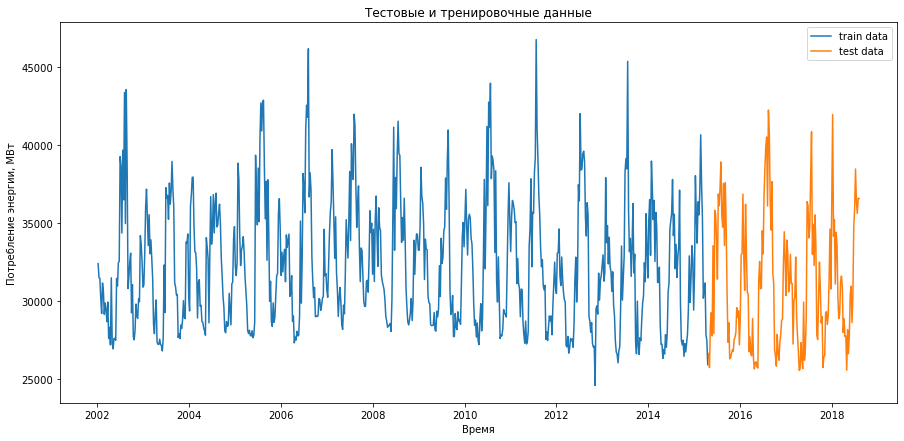

In [31]:
train, test = split_data_proportion(energy_w, part=0.8, need_split_date=False)

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [32]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

В качестве модели возьмем градиентный бустинг и сразу подберем ему лучшие гиперпараметры.

In [33]:
from sklearn.model_selection import GridSearchCV

papameters = [{'n_estimators': np.arange(100, 800, 100),
               'max_depth': np.arange(2, 9), 
               'min_samples_leaf': np.arange(1, 6)}]

clf = GridSearchCV(estimator=GradientBoostingRegressor(random_state=21, n_iter_no_change=30),
                   param_grid=papameters,
                   scoring='r2',
                   n_jobs=-1)

clf.fit(X_train, y_train)

clf.best_params_

{'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 100}

In [34]:
model_g = GradientBoostingRegressor(max_depth=2, random_state=21, n_estimators=100, min_samples_leaf=3)

model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
y_test_pred_g = model_g.predict(X_test)

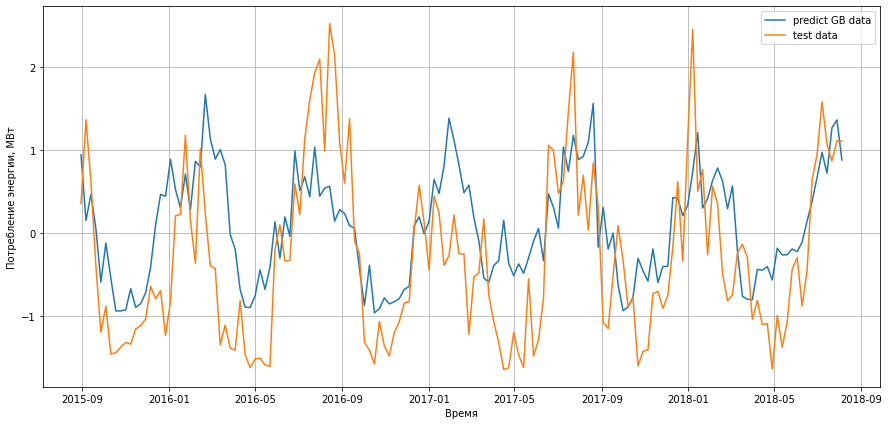

In [36]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+g:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+g:],y_test, label='test data')

plt.legend()
plt.grid()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [38]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('Ошибка mse :  ', er_s,'\nОшибка mae  :  ', er_a,'\nОценка R2 :  ', er_r2)

Ошибка mse :   0.735613583385203 
Ошибка mae  :   0.7071893623903144 
Оценка R2 :   0.27110634691053215


__3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.__

Пересоберем массивы с глубиной h=1, определим важные признаки и обучим модель.

In [39]:
scl_target=StandardScaler()

g = max(p, q)
h = 1

target = energy_w['PJME_MW'].values[h+g:].reshape((energy_w.shape[0]-h-g,1))
y = scl_target.fit_transform(target)

In [40]:
scl_x=StandardScaler() 

X = energy_w.iloc[g:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

In [41]:
best_f_score_colmns = []
threshold_f = 0.5

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
#     print("F-test={:.2f},  I={}".format(f_test[i],i))
    if f_test[i] > threshold_f:
        best_f_score_colmns.append(i)

In [42]:
column_names_f = energy_w.iloc[g:-h,:].columns[best_f_score_colmns]
print(column_names_f)

Index(['PJME_MW', 'log_mw', 'roll_4', 'q_1'], dtype='object')


In [43]:
sfk =SelectKBest(f_regression, k=7)
X_new1 =sfk.fit_transform(X, y.ravel())
column_names_k = energy_w.columns[sfk.get_support()]
column_names_k

Index(['PJME_MW', 'log_mw', 'roll_4', 'roll_5', 'q_1', 'p_6', 'p_7'], dtype='object')

In [44]:
sfp=SelectPercentile(f_regression, percentile=15)
X_new2 = sfp.fit_transform(X, y.ravel())
column_names_p = energy_w.columns[sfp.get_support()]
column_names_p

Index(['PJME_MW', 'log_mw', 'roll_4', 'roll_5', 'q_1', 'p_7'], dtype='object')

In [45]:
list_param = list(set(column_names_f.append(column_names_k).append(column_names_p)))
print(list_param)

['p_7', 'PJME_MW', 'roll_5', 'q_1', 'log_mw', 'p_6', 'roll_4']


Разделим данные на train и test.

In [46]:
numb_columns = [energy_w.columns.get_loc(param) for param in list_param]
X_new = X[:, numb_columns]

In [47]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

Так как количество переменных не изменилось по стравнению с h=1, то используем те же гиперпараметры модели.

In [48]:
model_g = GradientBoostingRegressor(max_depth=2, random_state=21, n_estimators=100, min_samples_leaf=3)

model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [49]:
y_test_pred_g = model_g.predict(X_test)

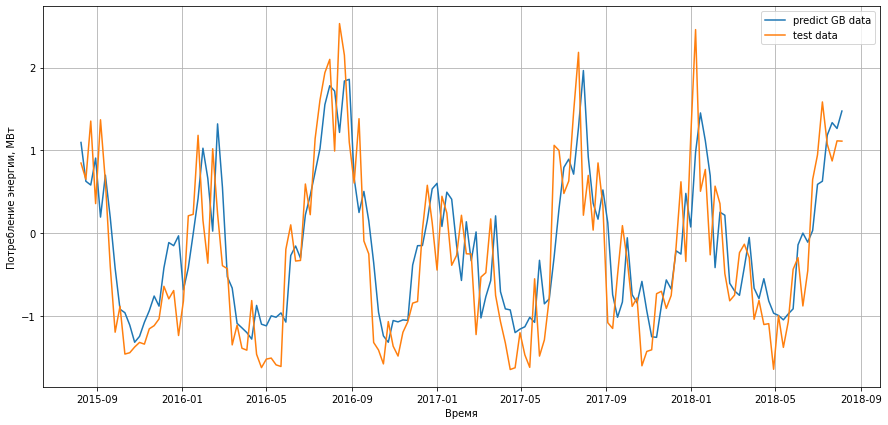

In [50]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+g:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+g:],y_test, label='test data')

plt.legend()
plt.grid()
plt.show()

In [51]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('Ошибка mse :  ', er_s,'\nОшибка mae  :  ', er_a,'\nОценка R2 :  ', er_r2)

Ошибка mse :   0.3700006077475119 
Ошибка mae  :   0.4953511238662231 
Оценка R2 :   0.6374766675961112


Модели для h=4 и h=1 имеют разную точность, которая отличается в несколько раз. Модель с меньшей глубиной прогноза предсказывает лучше. При выборе признаков для модели h=4 ни один их методов анализа не посчитал исходный параметр 'PJME_MW' как значимый. Данный результат вполне обоснован, так как при предсказании 4-ой точки от текущей больший вес имеет история и разности k-порядка, чем текущее значение, что обусловлено большей корреляцией признаков.

__4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.__

Поскольку рекурсивная модель предсказывает на один шаг вперед на каждой итерации, то возьмем признаки и гиперпараметры предыдущей модели при h=1.

In [52]:
# model_params = ['PJME_MW', 'log_mw', 'roll_mw', 'q_1', 'p_7']
model_params = ['log_mw', 'q_1', 'roll_4', 'roll_5', 'PJME_MW', 'p_6', 'p_7']

scl_target = StandardScaler()

p = 7 # глубина истории
h = 1

target = energy_w['PJME_MW'].values[h+p:].reshape((energy_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

scl_x = StandardScaler() 

X = energy_w.iloc[p:-h,:].values

numb_columns = [energy_w.columns.get_loc(param) for param in model_params]

X_new = scl_x.fit_transform(X[:, numb_columns].astype('float64'))

ones_ar = np.ones((1, len(numb_columns)))

train, test = split_data_proportion(energy_w, part=0.8, need_split_date=False)

X_train = X_new[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X_new[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

X_test_rec = X_test.copy()
y_test_rec = y_test.copy()

model_g_rec = GradientBoostingRegressor(max_depth=3, random_state=21, n_estimators=100, min_samples_leaf=3)
model_g_rec.fit(X_train, y_train)

y_test_pred_line = model_g_rec.predict(X_test)

In [53]:
for i in range(p, len(y_test_rec)-1): # для сохранения истории начнем с 7 (разность 7-порядка)
# ['log_mw', 'q_1', 'roll_4', 'roll_5', 'PJME_MW', 'p_6', 'p_7']
    y_test_rec[i] = model_g_rec.predict(X_test_rec[i,:].reshape(1, len(model_params)))
    
    y_inv_hist = scl_target.inverse_transform(y_test_rec[i-p:i])
    d = len(y_inv_hist) - 1
    
    ones_ar[0, 0] = np.log(y_inv_hist[d])
    ones_ar[0, 1] = y_inv_hist[d-1]
    ones_ar[0, 2] = np.mean(y_inv_hist[d-4:d])
    ones_ar[0, 3] = np.mean(y_inv_hist[d-5:d])
    ones_ar[0, 4] = y_inv_hist[d]
    ones_ar[0, 5] = y_inv_hist[d] - y_inv_hist[d-6]
    ones_ar[0, 6] = y_inv_hist[d] - y_inv_hist[d-7]
    
    ones_sc = scl_x.transform(ones_ar)
    
    X_test_rec[i+1, 0] = ones_sc[0, 0]
    X_test_rec[i+1, 1] = ones_sc[0, 1]
    X_test_rec[i+1, 2] = ones_sc[0, 2]
    X_test_rec[i+1, 3] = ones_sc[0, 3]
    X_test_rec[i+1, 4] = ones_sc[0, 4]
    X_test_rec[i+1, 5] = ones_sc[0, 5]
    X_test_rec[i+1, 6] = ones_sc[0, 6]


rec_data = scl_target.inverse_transform(y_test_rec[p:-h])
test_data = scl_target.inverse_transform(y_test[p:-h])
line_data = scl_target.inverse_transform(y_test_pred_line[p:-h])

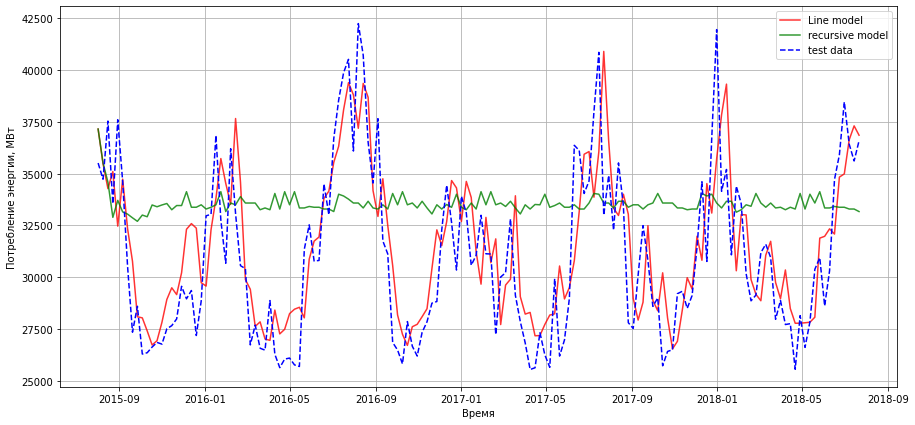

Ошибка mse :   1.3320096133422752 
Ошибка mae  :   0.9736489230626141 
Оценка R2 :   -0.27025565073672686


In [54]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[2*p:-2*h], line_data, 'r',label='Line model', alpha=0.8)
plt.plot(test.index[2*p:-2*h], rec_data, 'g',label='recursive model', alpha=0.8)
plt.plot(test.index[2*p:-2*h], test_data, '--b',label='test data')

plt.legend()
plt.grid()
plt.show()     
    
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_rec) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_rec) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_rec)

print('Ошибка mse :  ', er_s,'\nОшибка mae  :  ', er_a,'\nОценка R2 :  ', er_r2)

In [55]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
t = 4
print(f'Ошибки на {t} точке:')
print(f'MAPE line model: {mean_absolute_percentage_error(test_data[t], line_data[t])} %')
print(f'MAPE recursive model: {mean_absolute_percentage_error(test_data[t], rec_data[t])} %')

Ошибки на 4 точке:
MAPE line model: 13.651455340411875 %
MAPE recursive model: 10.347379686967443 %


__5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек).__

In [57]:
for j in range(0, 50, 10):
    er_100j = mean_absolute_percentage_error(y_true=test_data[j:j+10], y_pred=rec_data[j:j+10])
    r2 = r2_score(y_true=test_data[j:j+10], y_pred=rec_data[j:j+10])

    print(f'Ошибка рекурсивной модели на отрезке {j}:{j+10} MAPE: {er_100j} %, R2 = {r2}')

Ошибка рекурсивной модели на отрезке 0:10 MAPE: 9.95805316993946 %, R2 = 0.17205063799765297
Ошибка рекурсивной модели на отрезке 10:20 MAPE: 20.6568597117701 %, R2 = -25.93339785923463
Ошибка рекурсивной модели на отрезке 20:30 MAPE: 8.172337880837796 %, R2 = -0.2002946702869084
Ошибка рекурсивной модели на отрезке 30:40 MAPE: 24.22820925034031 %, R2 = -20.86876985289961
Ошибка рекурсивной модели на отрезке 40:50 MAPE: 11.376722779553491 %, R2 = -0.17274039957819998


__6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.__